# Classificação de Produtos

Vamos classificar e encontrar as features que mais impactam o modelo

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sns.set(rc={'figure.figsize':(18.7,8.27)})


In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
df = pd.read_csv('../data-insight-assessment-master/data/campaigns.csv', index_col='Unnamed: 0')
df.head(-10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45193,28,self-employed,single,tertiary,no,159,no,no,cellular,16,nov,449,2,33,4,success,yes
45194,59,management,married,tertiary,no,138,yes,yes,cellular,16,nov,162,2,187,5,failure,no
45195,68,retired,married,secondary,no,1146,no,no,cellular,16,nov,212,1,187,6,success,yes
45197,36,management,single,secondary,no,1511,yes,no,cellular,16,nov,270,1,-1,0,unknown,yes


In [4]:
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [5]:
df.head(-10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45193,28,self-employed,single,tertiary,no,159,no,no,cellular,16,nov,449,2,33,4,success,1
45194,59,management,married,tertiary,no,138,yes,yes,cellular,16,nov,162,2,187,5,failure,0
45195,68,retired,married,secondary,no,1146,no,no,cellular,16,nov,212,1,187,6,success,1
45197,36,management,single,secondary,no,1511,yes,no,cellular,16,nov,270,1,-1,0,unknown,1


In [6]:
X = df.drop('y', axis=1)
y = df['y']

In [7]:
def calculate_importance_FS(pipeline, dataset):
    model = pipeline.named_steps['classifier']
    selected = pipeline.named_steps['feature_selection']
    selected_cols = selected.get_support()
    cols = dataset.columns[selected_cols]
    feature_importance = pd.Series(data= model.feature_importances_, index = np.array(cols))
    feature_importance = feature_importance.sort_values(ascending=False).to_frame().head(10)
    return feature_importance

def calculate_importance(pipeline, dataset):
    model = pipeline.named_steps['classifier']
    cols = dataset.columns
    feature_importance = pd.Series(data= model.feature_importances_, index = np.array(cols))
    feature_importance = feature_importance.sort_values(ascending=False).to_frame().head(10)
    return feature_importance

def calculate_recall_score(pipeline, x_test, y_true):
    y_pred = pipeline.predict(x_test)
    return recall_score(y_true, y_pred)

def calculate_precision_score(pipeline, x_test, y_true):
    y_pred = pipeline.predict(x_test)
    return precision_score(y_true, y_pred)

In [8]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0,unknown
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success


In [9]:
#Transformação de features
X = pd.get_dummies(X, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome'], prefix=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome'])
X.head()

,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,261,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,44,29,151,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,33,2,76,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,47,1506,92,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,33,1,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [10]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_target, test_target = train_test_split(X, y, test_size=0.10, random_state=42)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.10, random_state=42)

## Baseline Model

In [12]:

# #Pipeline para dados numéricos
# numeric_features = x_train.drop(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome'], axis=1).columns
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')), #Usando a mediana para valores missing
#     ('scaler', StandardScaler())]) #Padronizando os inputs

# #Pipeline categórica
# categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contacta', 'day', 'month', 'poutcome']
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# #Agregando as duas pipelines
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)])

#Pipeline final
baseline_model=xgb.XGBClassifier()
baseline_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                      ('classifier', baseline_model)])

In [13]:

param_grid = {
    'classifier__scale_pos_weight':  [1, 10, 25, 50, 75, 99, 100, 1000],
}

In [14]:
tst = GridSearchCV(baseline_pipe, n_jobs=-1, scoring='precision', param_grid=param_grid, cv=5)

In [15]:
tst.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                           

In [16]:
recall = calculate_recall_score(tst, x_val,  y_val)
print('Score para baseline_model no conjunto de validação:', recall)
recall = calculate_recall_score(tst, test_features,  test_target)
print('Score para baseline_model no conjunto de teste:', recall)

Score para baseline_model no conjunto de validação: 0.5331695331695332
Score para baseline_model no conjunto de teste: 0.47904191616766467


In [17]:
prec = calculate_precision_score(tst, x_val,  y_val)
print('Score para baseline_model no conjunto de validação:', prec)
prec = calculate_precision_score(tst, test_features,  test_target)
print('Score para baseline_model no conjunto de teste:', prec)

Score para baseline_model no conjunto de validação: 0.62
Score para baseline_model no conjunto de teste: 0.6266318537859008


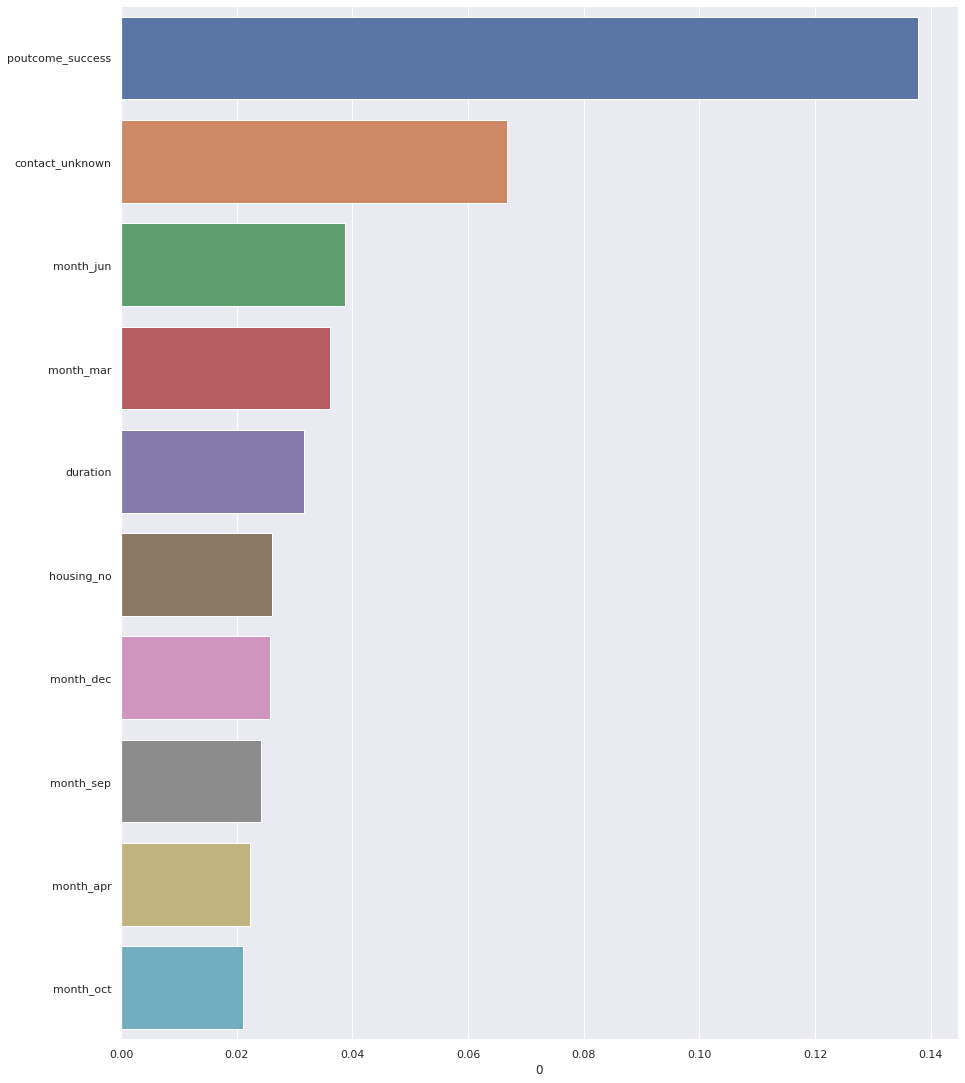

In [18]:
fe = calculate_importance(tst.best_estimator_, X)
plt.figure(figsize=(15,19))
sns.barplot(x=0,
            y=fe.index,
            data=fe)

## Balanceando Dataset - Oversampling

* Vou separar em train, val e test;
* O conjunto de val vai derivar do cojunto de treino;
* Fazer o upsample apenas no conjunto de treino.

In [19]:
#Pipeline final
ovs_model=xgb.XGBClassifier()
ovs_pipe = Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                           ('scaler', StandardScaler()),
                      ('classifier', ovs_model)])

In [20]:
param_grid = {
    'classifier__scale_pos_weight':  [1, 10, 25, 50, 75, 99, 100, 1000],
}

ovs_cv = GridSearchCV(ovs_pipe, n_jobs=-1, scoring='precision', param_grid=param_grid, cv=5)

In [21]:
ovs_cv.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                    

In [22]:
recall = calculate_recall_score(ovs_cv, x_val,  y_val)
print('Score para baseline_model no conjunto de validação:', recall)
recall = calculate_recall_score(ovs_cv, test_features,  test_target)
print('Score para baseline_model no conjunto de teste:', recall)

Score para baseline_model no conjunto de validação: 0.5626535626535627
Score para baseline_model no conjunto de teste: 0.5269461077844312


In [23]:
prec = calculate_precision_score(ovs_cv, x_val,  y_val)
print('Score para baseline_model no conjunto de validação:', prec)
prec = calculate_precision_score(ovs_cv, test_features,  test_target)
print('Score para baseline_model no conjunto de teste:', prec)

Score para baseline_model no conjunto de validação: 0.6122994652406417
Score para baseline_model no conjunto de teste: 0.6270783847980997


## Feature Importance - OverSampling

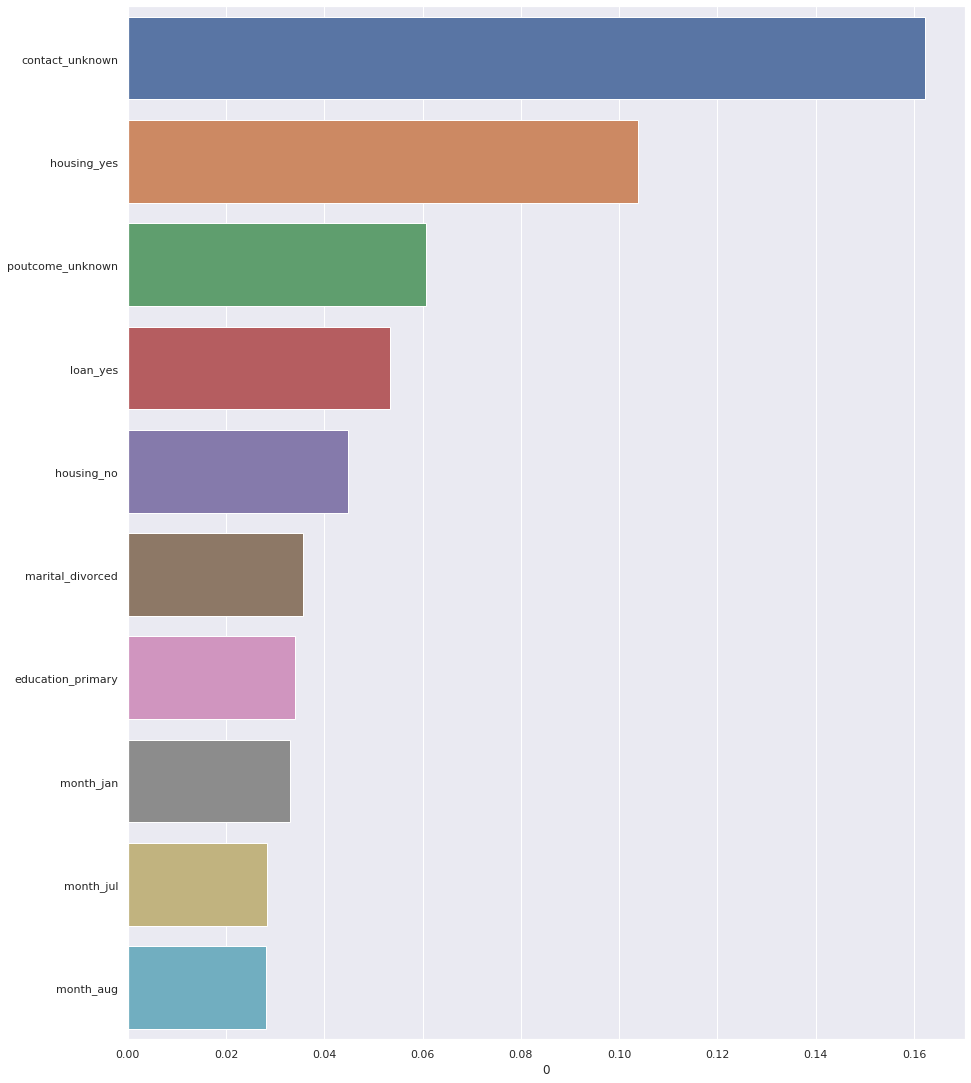

In [24]:
fe = calculate_importance(ovs_cv.best_estimator_, X)
plt.figure(figsize=(15,19))
sns.barplot(x=0,
            y=fe.index,
            data=fe)

## Feature Selection + OverSampling

In [25]:
fs_model=xgb.XGBClassifier()
class_model = xgb.XGBClassifier()
fs_pipe = Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                           ('scaler', StandardScaler()),
                           ('feature_selection', SelectFromModel(fs_model, threshold='1.25*median')),
                           ('classifier', class_model)])

In [26]:
param_grid = {
    'classifier__scale_pos_weight':  [1, 10, 25, 50, 75, 99, 100, 1000],
}

fs_cv = GridSearchCV(fs_pipe, n_jobs=-1, scoring='precision', param_grid=param_grid, cv=5)

In [27]:
fs_cv.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                                                booster=None,
                                                                                colsample_bylevel=None,
                                                                                colsample_bynode=None,
                                                                                colsample_bytree=None,
                                                                                gamma=None,
                                                                                gpu_id=None,
                                                                                importan

In [28]:
recall = calculate_recall_score(fs_cv, x_val,  y_val)
print('Score para baseline_model no conjunto de validação:', recall)
recall = calculate_recall_score(fs_cv, test_features,  test_target)
print('Score para baseline_model no conjunto de teste:', recall)

Score para baseline_model no conjunto de validação: 0.5454545454545454
Score para baseline_model no conjunto de teste: 0.4810379241516966


In [29]:
prec = calculate_precision_score(fs_cv, x_val,  y_val)
print('Score para baseline_model no conjunto de validação:', prec)
prec = calculate_precision_score(fs_cv, test_features,  test_target)
print('Score para baseline_model no conjunto de teste:', prec)

Score para baseline_model no conjunto de validação: 0.5904255319148937
Score para baseline_model no conjunto de teste: 0.5950617283950618


In [30]:
fe = calculate_importance_FS(fs_cv.best_estimator_, X)

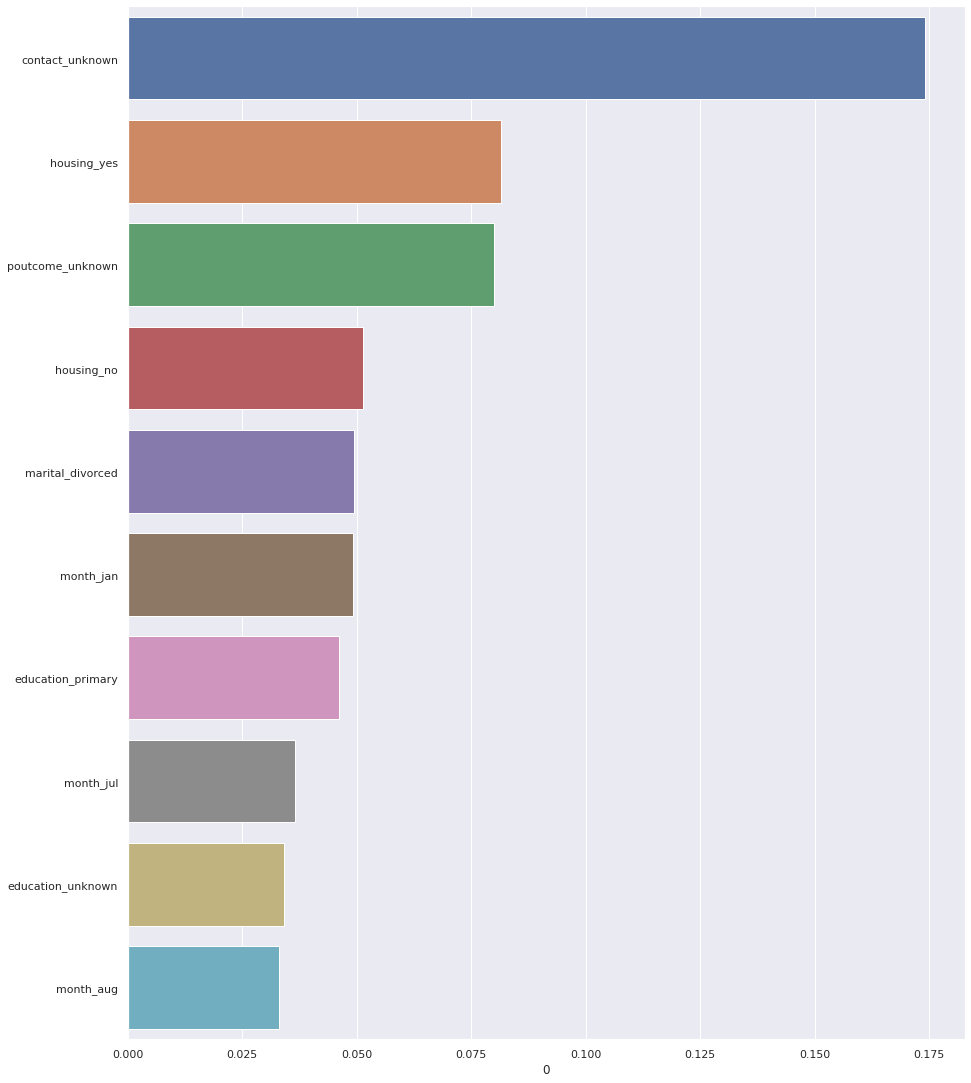

In [31]:
plt.figure(figsize=(15,19))
sns.barplot(x=0,
            y=fe.index,
            data=fe)

## Melhor Modelo

Nosso melhor modelo foi o ovs_cv, nele utilizamos:
* Balanceamento de dataset com SMOTE;
* CV = 5;
* xgbClassifier

Vamos salvar o mesmo.

In [32]:
import joblib

joblib.dump(ovs_cv, '../modelos/best_model.pkl')

['../modelos/best_model.pkl']

In [33]:
#Gerando csv do conjunto de teste
def generate_preds(dataset, model):
    dummie = dataset.copy()
    dummie = pd.get_dummies(dummie, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome'], prefix=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome']).drop('y', axis=1)
    dataset['y_pred'] = model.predict(dummie)
    
    return dataset

new_df = generate_preds(df, ovs_cv)

In [132]:
new_df.to_csv('../preds/predicts.csv', index=False)

In [23]:
teste = df.iloc[0].to_frame().reset_index()

# Conclusões:

Para selecionar o melhor modelo, utilizei a métrica de Recall e Precision.

O melhor modelo é aquele em que os scores no conjunto de teste e de validação mais se aproximam. No nosso caso, é o modelo onde o oversampling foi feito de forma direta, sem o uso de feature selection.